In [1]:
import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
import imageio, os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
tf.test.is_gpu_available()

Using TensorFlow backend.
D:\Anaconda\Anaconda\envs\env_tf1.8\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\Anaconda\envs\env_tf1.8\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\Anaconda\envs\env_tf1.8\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\Anaconda\envs\env_tf1.8\lib\site-pa

True

In [2]:
# configuration
batch_size = 128
latent_dim = 32
epochs = 50
num_classes = 10
img_dim = 28
filters = 16
intermediate_dim = 256

In [3]:
# load MNIST dataset
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
train_data = np.vstack([x_train,x_test])
train_labels = np.hstack([y_train_,y_test_])
train_data = train_data.astype('float32') / 255.
train_data = train_data.reshape((-1, img_dim, img_dim, 1)) # (60000,28,28,1)

In [4]:
# ===============================build==============================

x = Input(shape=(img_dim, img_dim, 1)) # (28,28,1)
h = x

for i in range(2):
    filters *= 2
    h = Conv2D(filters=filters,
               kernel_size=3,
               strides=2,
               padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=filters,
               kernel_size=3,
               strides=1,
               padding='same')(h)
    h = LeakyReLU(0.2)(h)

h_shape = K.int_shape(h)[1:] # (14,14,64)
h = Flatten()(h)
z_mean = Dense(latent_dim)(h)  # p(z|x) mean
z_log_var = Dense(latent_dim)(h)  # p(z|x) log variance

# build encoder
encoder = Model(x, z_mean) 

z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

for i in range(2):
    h = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=1,
                        padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=2,
                        padding='same')(h)
    h = LeakyReLU(0.2)(h)
    filters //= 2

x_recon = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same')(h)

# build decoder out_dim=(B,28,28,1)
decoder = Model(z, x_recon)  
generator = decoder

# build classfier
z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)

classfier = Model(z, y) 


# reparameterisation trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classfier(z) # (B,K)


class Gaussian(Layer):
    """
    define parameters of q(z|y) ——means
    output“z - means”，ready for computing loss
    """

    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                                    shape=(self.num_classes, latent_dim),
                                    initializer='zeros')
        

    def call(self, inputs):
        z = inputs  # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0) # (B,1,latent_dim) - (1,K,latent_dim) = (B,K,latent_dim)

    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])


gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)

# build our rvadc model
rvadc = Model(x, [x_recon, z_prior_mean, y])

# ready for loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)
z = K.expand_dims(z, 1) # (B,1,latent_dim)
z_post_mean = 0.5 * (K.square(z - z_mean)/(1e-8+K.exp(z_log_var))) # (B,1,latent_dim)
batch_y = K.mean(y,0) # (K,)

# hyper-parameters
rou = 2.5  # refer ρ
yita = 2.7 # refer η
gamma = 6.3 # refer γ

# reconstruction error
xent_loss = 0.5 * K.mean((x - x_recon) ** 2, 0)

# conditional error
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean)) - z_post_mean  # (B,K,latent_dim)
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)

# prior error (anti-clustering term)
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)

# sample-wise entropy
batch_entropy = -batch_y * K.log(batch_y + K.epsilon())

# batch-wise entropy
samples_entropy = K.mean(-y * K.log(y + K.epsilon()),0)

rvadc_loss = rou * K.sum(xent_loss) + K.sum(kl_loss) - gama * K.sum(batch_entropy)  + yita * K.sum(samples_entropy) + K.sum(cat_loss)

rvadc.add_loss(rvadc_loss)
rvadc.compile(optimizer='adam') 
rvadc.summary()

# Just load model

# history = rvadc.fit(train_data,
#         shuffle=True,
#         epochs=epochs,
#         batch_size=batch_size,)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   9248        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [5]:
# vae.save_weights('./RVaDC')
rvadc.load_weights('./RVaDC')

In [7]:
# get predictions
means = K.eval(gaussian.mean) # (K,latent_dim)
x_train_encoded = encoder.predict(train_data) # (70000,latent_dim)
y_train_pred = classfier.predict(x_train_encoded).argmax(axis=1) # (70000,)

# get accuracy
right = 0.

for i in range(10):
    
    _ = np.bincount(train_labels[y_train_pred == i])
    right += _.max()

print('Clustering Accuracy: %s' % (right / len(train_labels)))

Clustering Accuracy: 0.9590142857142857


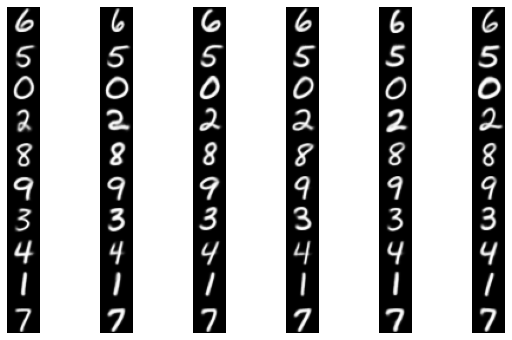

In [60]:
def random_sample_plot_all():
    """
    plot each cluster
    """
    n = 6
    fig = plt.figure(figsize=(10,n))
    for i in range(num_classes): # 控制类别
        
        for j in range(n):
            
            plt.subplot(num_classes,n,i*n+j+1)
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape)) * 0.5 + means[i]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            
            plt.imshow(digit,cmap='gray')
            
            plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.show()

random_sample_plot_all()

In [8]:
def random_save_sample(path):
    """按照聚类结果进行条件随机生成
    """

    n = 10
    figure = np.zeros((img_dim * n, img_dim * 10))
    for i in range(n):
        for j in range(10):
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape))*0. + means[i]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)
    
random_save_sample(r'E:\clustering.png')

Lossy conversion from float64 to uint8. Range [2.415579216543339e-22, 252.26793140172958]. Convert image to uint8 prior to saving to suppress this warning.


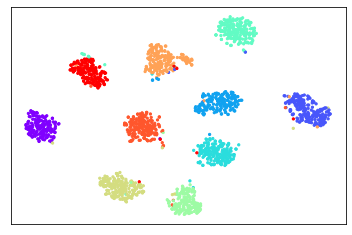

In [12]:
# plot latent space on MNIST dataset
fig = plt.figure()
tsne = TSNE()
plt_size =2000
i = 1 
z = x_train_encoded[plt_size*i:plt_size*(i+1),:]
z = tsne.fit_transform(z)
plt.scatter(z[:, 0], z[:, 1], c=train_labels[plt_size*i:plt_size*(i+1)], cmap='rainbow',s=5)
plt.xticks([])
plt.yticks([])
# plt.savefig(r'path to save this image')

plt.show()